In [7]:
from pennylane import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
from scipy.linalg import expm
from copy import deepcopy
import pennylane as qml
import pandas as pd
from math import pi
import numpy as np
import random
import torch

In [8]:
devSet = pd.read_csv("./us_migration.csv")
devSet = devSet.loc[:, ~devSet.columns.str.contains('^Unnamed')]
devSet = devSet.apply(lambda x: pd.to_numeric(x, errors='coerce'))
devSet = devSet.dropna(axis=1)

y = torch.Tensor(devSet['US_MIG_05_10'].values)
X = devSet.loc[:, devSet.columns != "US_MIG_05_10"].values

mMScale = preprocessing.MinMaxScaler()
X = mMScale.fit_transform(X)

indices = random.sample(range(0, 10), 5)

In [38]:
[i for i in range(5)]
[i % 5 for i in range(8)]

[0, 1, 2, 3, 4, 0, 1, 2]

In [39]:
[i % 5 for i in range(8)][0:4]

[0, 1, 2, 3]

In [40]:
[i % 5 for i in range(8)][4:]

[4, 0, 1, 2]

In [136]:
devX = qml.device('default.qubit', wires = 5)
devY = qml.device('default.qubit', wires = 5)
devZ = qml.device('default.qubit', wires = 5)

@qml.qnode(devX)
def rotation_circuitX(vals, thetas):

    # Apply Hadamards
    for hadamard_wire in range(len(vals)):
        qml.Hadamard(wires = hadamard_wire)

    # Apply value dependent Z-axis rotations
    for rotation_val in range(len(vals)):
        qml.RZ(vals[rotation_val], wires = rotation_val)



    # Parametized rotation <- this is what is being trained
    # ws = [i for i in range(len(vals))]

    theta_indices = [i % len(vals) for i in range(len(thetas))]
    curIn = [0,1,2,3]
    for theta in range(len(curIn)):
        qml.RX(thetas[theta], wires=curIn[theta])

    # CNOT's
    qml.CNOT(wires = [0,1])
    qml.CNOT(wires = [1,2])
    qml.CNOT(wires = [2,3])
    qml.CNOT(wires = [3,4])

    theta_indices = [i % len(vals) for i in range(len(thetas))]
    curIn = [4,5,6,7]
    for theta in range(len(curIn)):
        qml.RX(thetas[curIn[theta]], wires=theta)

    # CNOT's
    qml.CNOT(wires = [1,0])
    qml.CNOT(wires = [2,1])
    qml.CNOT(wires = [3,2])
    qml.CNOT(wires = [4,3])


    # Get expected values & return them
    expected_values = [qml.expval(qml.PauliX(wire)) for wire in range(len(vals))]
    return expected_values


@qml.qnode(devY)
def rotation_circuitY(vals, thetas):

    # Apply Hadamards
    for hadamard_wire in range(len(vals)):
        qml.Hadamard(wires = hadamard_wire)

    # Apply value dependent Z-axis rotations
    for rotation_val in range(len(vals)):
        qml.RZ(vals[rotation_val], wires = rotation_val)



    # Parametized rotation <- this is what is being trained
    theta_indices = [i % len(vals) for i in range(len(thetas))]
    curIn = [0,1,2,3]
    for theta in range(len(curIn)):
        qml.RX(thetas[theta], wires=curIn[theta])

    # CNOT's
    qml.CNOT(wires = [0,1])
    qml.CNOT(wires = [1,2])
    qml.CNOT(wires = [2,3])
    qml.CNOT(wires = [3,4])

    theta_indices = [i % len(vals) for i in range(len(thetas))]
    curIn = [4,5,6,7]
    for theta in range(len(curIn)):
        qml.RX(thetas[curIn[theta]], wires=theta)

    # CNOT's
    qml.CNOT(wires = [1,0])
    qml.CNOT(wires = [2,1])
    qml.CNOT(wires = [3,2])
    qml.CNOT(wires = [4,3])

    # Get expected values & return them
    expected_values = [qml.expval(qml.PauliY(wire)) for wire in range(len(vals))]
    return expected_values


@qml.qnode(devZ)
def rotation_circuitZ(vals, thetas):

    # Apply Hadamards
    for hadamard_wire in range(len(vals)):
        qml.Hadamard(wires = hadamard_wire)

    # Apply value dependent Z-axis rotations
    for rotation_val in range(len(vals)):
        qml.RZ(vals[rotation_val], wires = rotation_val)



    # Parametized rotation <- this is what is being trained
    theta_indices = [i % len(vals) for i in range(len(thetas))]
    curIn = [0,1,2,3]
    for theta in range(len(curIn)):
        qml.RX(thetas[theta], wires=curIn[theta])

    # CNOT's
    qml.CNOT(wires = [0,1])
    qml.CNOT(wires = [1,2])
    qml.CNOT(wires = [2,3])
    qml.CNOT(wires = [3,4])

    # Parametized rotation <- this is what is being trained
    theta_indices = [i % len(vals) for i in range(len(thetas))]
    curIn = [4,5,6,7]
    for theta in range(len(curIn)):
        qml.RX(thetas[curIn[theta]], wires=theta)

    # CNOT's
    qml.CNOT(wires = [1,0])
    qml.CNOT(wires = [2,1])
    qml.CNOT(wires = [3,2])
    qml.CNOT(wires = [4,3])

    # Get expected values & return them
    expected_values = [qml.expval(qml.PauliZ(wire)) for wire in range(len(vals))]
    return expected_values


In [145]:
###### Define our model
class QuantumCicuitNet(torch.nn.Module):
    def __init__(self, n_vals, n_dim, batch_size):
        super().__init__()
        self.relu = torch.nn.ReLU(inplace=True)
        self.conv2d = torch.nn.Conv2d(3, 1, kernel_size=(3,3), stride=(2,2), padding=(2,2), bias=False)
        self.linear = torch.nn.Linear(batch_size*1*4*2, n_dim)  


    def param_shift(self, vals, thetas):

        mean_grads = []

        for batch in range(len(vals)):

            cur_vals = vals[batch]
            gradXs, gradYs, gradZs = [], [], []

            for i in range(len(thetas)):

                cur_rs, cur_ls = deepcopy(thetas), deepcopy(thetas)
                cur_rs[i], cur_ls[i] = cur_rs[i] + (np.pi / 2), cur_ls[i] - (np.pi / 2)

                # print("RS: ", cur_rs)
            

                # Get the ouput of a shift right and left for each of the X, Y and Z circuits (output shape is 5 for each of the variables/qubits)
                r_plusX  = rotation_circuitX(cur_vals, np.array(cur_rs))
                r_minusX = rotation_circuitX(cur_vals, np.array(cur_ls))
                r_plusY  = rotation_circuitY(cur_vals, np.array(cur_rs))
                r_minusY = rotation_circuitY(cur_vals, np.array(cur_ls))
                r_plusZ  = rotation_circuitZ(cur_vals, np.array(cur_rs))
                r_minusZ = rotation_circuitZ(cur_vals, np.array(cur_ls))

                # print("R MINUS: ", r_minusX, "  R Plus: ", r_plusX)

                # using the convention u=1/2
                # Caculate the gradient (shape here is 5 again)
                gradX = torch.tensor(.5 * (r_plusX - r_minusX))
                gradY = torch.tensor(.5 * (r_plusY - r_minusY))
                gradZ = torch.tensor(.5 * (r_plusZ - r_minusZ))  

                # Append the maximum gradient to the list of overall gradients
                gradXs.append(torch.max(gradX).detach().numpy())
                gradYs.append(torch.max(gradY).detach().numpy())
                gradZs.append(torch.max(gradZ).detach().numpy())
            
            cur_grads = torch.tensor(np.reshape(np.concatenate([gradXs, gradYs, gradZs]), (3, 8)))
            cur_means = torch.mean(input = cur_grads, dim = 0)
            mean_grads.append(cur_means)

            # print("MEAN GRADS")
            # print(mean_grads)

        mean_grads = torch.tensor([i.detach().numpy() for i in mean_grads])
        mean_grads = torch.reshape(torch.tensor(mean_grads), (len(vals), len(thetas)))
        mean_grads = torch.mean(input = mean_grads, dim = 0)

        return mean_grads


    def run_circs(self, x, thetas):
        outs = []
        for i in range(0, x.shape[0]):
            outX = torch.tensor(rotation_circuitX(x[i], thetas), dtype = torch.float32) * 100# OUT:  torch.Size([100, 1, 10, 10])
            outY = torch.tensor(rotation_circuitY(x[i], thetas), dtype = torch.float32) * 100# OUT:  torch.Size([100, 1, 10, 10])
            outZ = torch.tensor(rotation_circuitZ(x[i], thetas), dtype = torch.float32) * 100# OUT:  torch.Size([100, 1, 10, 10])
            outs.append(torch.reshape(torch.cat((outX, outY,outZ), 0), (3, 5)))
        return torch.reshape(torch.cat(outs), (x.shape[0], 3, x.shape[1], 1))

        
    def forward(self, x, thetas):
        out = self.run_circs(x, thetas)
        grads = self.param_shift(x, thetas)
        out = self.conv2d(out)
        out = self.relu(out)
        out = out.flatten()
        out = self.linear(out)
        return out, grads

In [146]:
def mae(real, pred):
    '''
    Calculates MAE of an epoch
    '''
    return torch.abs(real - pred).mean()

## Training without the theta updates

In [159]:
losses_no_circ, maes_no_circ = [], []

n_vals = 5
n_dim = 5
lr = 1e-6
theta_lr = .10 #00000000
thetas = [.5] * 8
batch_size = 5

model = QuantumCicuitNet(n_vals, n_dim, batch_size)

criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr = lr)



for i in range(0, 100):

    print("EPOCH: ", i)

    batch_obs = random.sample(range(0, len(X)), 5)

    x = np.array([list(i)[0:5] for i in X[batch_obs]])
    Y = torch.tensor(y.detach().numpy()[batch_obs])

    y_pred, grad = model(torch.tensor(x), thetas)
    loss = criterion(y_pred, Y)
    cur_losses.append(loss)
    

    print("    Loss: ", loss)
    print("    MAE:  ", mae(y_pred, Y))
    print("    Y T:  ", Y)
    print("    Y P:  ", y_pred)

    cur_maes.append(mae(y_pred, Y))


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    thetas = [i.item() for i in list(torch.tensor(thetas) + (grad * theta_lr))]

    print("    Thetas: ", torch.tensor(thetas) + grad * theta_lr)

    print("\n")




rd0>)
    Thetas:  tensor([0.5000, 0.5307, 0.5073, 0.5053, 0.5016, 0.5289, 0.5064, 0.6931],
       dtype=torch.float64)


EPOCH:  49
    Loss:  tensor(260561.2500, grad_fn=<MseLossBackward>)
    MAE:   tensor(173.0223, grad_fn=<MeanBackward0>)
    Y T:   tensor([ 51., 574.,  12., 201., 109.])
    Y P:   tensor([140.7966, 103.9146, 129.9733, 101.5675, 196.8239],
       grad_fn=<AddBackward0>)
    Thetas:  tensor([0.5000, 0.5314, 0.5073, 0.5053, 0.5016, 0.5296, 0.5065, 0.6991],
       dtype=torch.float64)


EPOCH:  50
    Loss:  tensor(73703.1328, grad_fn=<MseLossBackward>)
    MAE:   tensor(101.3876, grad_fn=<MeanBackward0>)
    Y T:   tensor([273., 170., 271., 105.,  26.])
    Y P:   tensor([149.0271, 190.6124, 115.8593, 129.9549, 208.2569],
       grad_fn=<AddBackward0>)
    Thetas:  tensor([0.5000, 0.5312, 0.5073, 0.5053, 0.5016, 0.5294, 0.5065, 0.6990],
       dtype=torch.float64)


EPOCH:  51
    Loss:  tensor(961485.9375, grad_fn=<MseLossBackward>)
    MAE:   tensor(297.0391, grad

In [71]:
thetas

[0.5291187428001014,
 0.5182355232192323,
 0.5036585542213845,
 0.5017569469706846,
 0.5,
 0.5,
 0.5,
 0.5]

In [160]:
obs = [[i for i in range(0, 200)][i:i + 5] for i in range(0, len([i for i in range(0, 200)]), 5)]

In [161]:
preds_df = pd.DataFrame()
preds = []
trues = []

for i in obs:
    print(i)
    inp = np.array([list(i)[0:5] for i in X[i]])
    ys = torch.tensor(y.detach().numpy()[i])
    pred, _ = model(torch.tensor(inp), thetas)
    
    preds += list(pred.detach().numpy())
    trues += ys
    # preds += list(pred.detach().numpy())

    
    print()

[0, 1, 2, 3, 4]
<ipython-input-145-269fe5669e4e>:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean_grads = torch.reshape(torch.tensor(mean_grads), (len(vals), len(thetas)))

[5, 6, 7, 8, 9]

[10, 11, 12, 13, 14]

[15, 16, 17, 18, 19]

[20, 21, 22, 23, 24]

[25, 26, 27, 28, 29]

[30, 31, 32, 33, 34]

[35, 36, 37, 38, 39]

[40, 41, 42, 43, 44]

[45, 46, 47, 48, 49]

[50, 51, 52, 53, 54]

[55, 56, 57, 58, 59]

[60, 61, 62, 63, 64]

[65, 66, 67, 68, 69]

[70, 71, 72, 73, 74]

[75, 76, 77, 78, 79]

[80, 81, 82, 83, 84]

[85, 86, 87, 88, 89]

[90, 91, 92, 93, 94]

[95, 96, 97, 98, 99]

[100, 101, 102, 103, 104]

[105, 106, 107, 108, 109]

[110, 111, 112, 113, 114]

[115, 116, 117, 118, 119]

[120, 121, 122, 123, 124]

[125, 126, 127, 128, 129]

[130, 131, 132, 133, 134]

[135, 136, 137, 138, 139]

[140, 141, 142, 143, 144]

[145, 146, 14

In [84]:
preds

[738.5281,
 273.87335,
 775.1601,
 902.008,
 211.5946,
 729.35364,
 270.48932,
 769.1065,
 893.63947,
 210.57365]

In [85]:
ys

tensor([ 337.,  204.,  320.,   61., 2063.])

In [162]:
preds_df['true'] = trues
preds_df['true'] = preds_df['true'].astype(int)
preds_df['pred'] = preds
preds_df.head()

,true,pred
0,961,211.008377
1,154,371.236877
2,905,130.940079
3,225,391.162872
4,1071,158.423676


In [163]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(preds_df['true'], preds_df['pred'])


454.9825577163696

In [164]:
from sklearn.metrics import mean_absolute_percentage_error

mean_absolute_percentage_error(preds_df['true'], preds_df['pred'])


0.719914099680905

In [170]:
0.719914099680905*100

71.99140996809051

In [165]:
from sklearn.metrics import r2_score

r2_score(preds_df['true'], preds_df['pred'])

-0.3868732918629465

In [166]:
def allocation_error(ytruelist, ypredlist):
    return abs((sum(ytruelist) - sum(ypredlist)) / len(ypredlist))


allocation_error(preds_df['true'], preds_df['pred'])

394.060453453064

In [167]:
def quantity_error(ytruelist, ypredlist): 
    return abs(sum(ytruelist) - sum(ypredlist))


quantity_error(preds_df['true'], preds_df['pred'])

78812.0906906128

In [168]:
preds_df.to_csv("./preds_df2.csv")

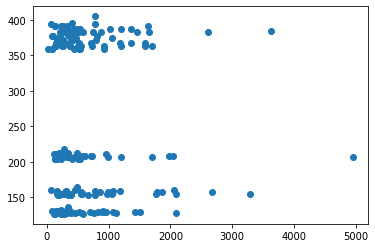

In [169]:
plt.scatter(preds_df['true'], preds_df['pred'])